In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import mlflow

rng = np.random.RandomState(1234)
random_state = 42

In [2]:
batch_size = 1  # 可視化の際に扱いやすくするために1とする．

# CIFER10の精度を競うことにする
# transforms.ToTensr: 入力データ（np.ndarrayなど）をPyTorchのテンソルに変換する．PyTorchで画像を扱うときは(バッチサイズ，チャネル数，高さ，幅）になるため注意．
dataloader_train = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data/cifar10', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=False
)

Files already downloaded and verified


Drop Out層の定義

In [3]:
class Dropout(nn.Module):
    def __init__(self, dropout_ratio=0.5):
        super().__init__()
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x):
        if self.training:
            self.mask = torch.rand(*x.size()) > self.dropout_ratio
            return x * self.mask.to(x.device)
        else:
            return x * (1.0 - self.dropout_ratio)

Batch_normで画像の正規化をする。これを最終的な層に組み込むことになる


In [4]:
class BatchNorm(nn.Module):
    def __init__(self, shape, epsilon=np.float32(1e-5)):
        super().__init__()
        self.gamma = nn.Parameter(torch.tensor(np.ones(shape, dtype='float32')))
        self.beta = nn.Parameter(torch.tensor(np.zeros(shape, dtype='float32')))
        self.epsilon = epsilon

    def forward(self, x):
        mean = torch.mean(x, (0, 2, 3), keepdim=True)  
        std = torch.std(x, (0, 2, 3), keepdim=True)  
        x_normalized = (x - mean) / (std**2 + self.epsilon)**0.5  
        return self.gamma * x_normalized + self.beta  

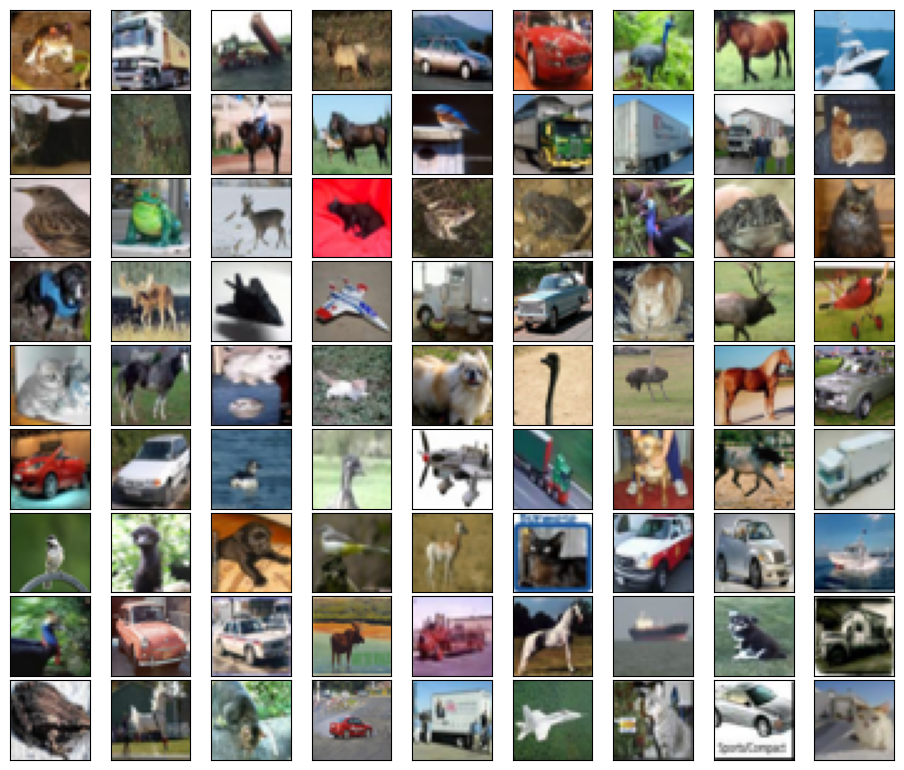

In [5]:

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

# データセットの画像を可視化
i = 0
for x, _ in dataloader_train:
    x = np.transpose(torch.squeeze(x).numpy(), (1, 2, 0))
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(x)
    i += 1
    if i >= 81:
        break


In [6]:
class Conv(nn.Module):
    def __init__(self, filter_shape, function=lambda x: x, stride=(1, 1), padding=0):
        super().__init__()
        # Heの初期化
        # filter_shape: (出力チャンネル数)x(入力チャンネル数)x(縦の次元数)x(横の次元数)
        fan_in = filter_shape[1] * filter_shape[2] * filter_shape[3]
        fan_out = filter_shape[0] * filter_shape[2] * filter_shape[3]

        self.W = nn.Parameter(torch.tensor(rng.normal(
                        0,
                        np.sqrt(2/fan_in),
                        size=filter_shape
                    ).astype('float32')))

        # バイアスはフィルタごとなので, 出力フィルタ数と同じ次元数
        self.b = nn.Parameter(torch.tensor(np.zeros((filter_shape[0]), dtype='float32')))

        self.function = function  
        self.stride = stride  
        self.padding = padding 

    def forward(self, x):
        u = F.conv2d(x, self.W, bias=self.b, stride=self.stride, padding=self.padding)
        return self.function(u)

In [7]:
class Pooling(nn.Module):
    def __init__(self, ksize=(2, 2), stride=(2, 2), padding=0):
        super().__init__()
        self.ksize = ksize  # カーネルサイズ
        self.stride = stride  # ストライド幅
        self.padding = padding  # パディング

    def forward(self, x):
        return F.avg_pool2d(x, kernel_size=self.ksize, stride=self.stride, padding=self.padding)

In [8]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x.view(x.size()[0], -1)

x.sizeで返ってくるのは、(Batch_size,Channel,Height,Width)のtuple型が返ってくるが、それの０番目を指定することでBatch_sizeが縦に並ぶベクトルのデータが出来上がる


In [9]:
class Dense(nn.Module):
    def __init__(self,in_dim,out_dim,function=lambda x:x):
        super().__init__()
        
        self.w = nn.Parameter((torch.tensor(rng.normal(0,np.sqrt(2/in_dim),size=(in_dim, out_dim)).astype('float32'))))

        self.b = nn.Parameter(torch.tensor(np.zeros([out_dim]).astype('float32')))
        self.function = function

    def forward(self,x):
        return self.function(torch.matmul(x,self.w)+self.b)


In [10]:
class Activation(nn.Module):
    def __init__(self, function=lambda x: x):
        super().__init__()
        self.function = function

    def __call__(self, x):
        return self.function(x)

In [11]:
def torch_log(x):
    return torch.log(torch.clamp(x, min=1e-10))

configでハイパーパラメータを管理する。最後のパラメータはピリオドになることの注意する

In [12]:
config={
    'batch_size': 100,
    'epochs': 50,
    'seed': 42,
    'lr': 0.01,
    'num_layers' : 3,
    'n_resch' : 64.
}

nv_netで実際のモデルを定義する。
画像のチャネル数はハイパーパラメータ扱いになる。これは自分で決めることができるし最適化されたパラメータがあるはず。
最初の畳み込み層のConvは引数が画像の (縦横のサイズ、チャネル数、カーネルの大きさ) になっていて、畳み込み計算のときにパディングをするので縦横の画像サイズは２だけ減る。
Batch_normalizationの引数は (チャネル数、縦のサイズ、横のサイズ) の順番
Pooling層は２×２なので純粋に画像のサイズが半分になる。
これを２×２のサイズまで持ってきて最後に平滑化させてDNNに入れて学習させる


In [13]:

conv_net = nn.Sequential(
    Conv((32, 3, 3, 3)),        # 画像の大きさ：32x32x3 -> 30x30x32  (入出力の画像サイズ）
    BatchNorm((32, 30, 30)),
    Activation(F.relu),
    Pooling((2, 2)),            # 30x30x32 -> 15x15x32  (入出力の画像サイズ）
    Conv((64, 32, 3, 3)),       # 15x15x32 -> 13x13x64  (入出力の画像サイズ）
    BatchNorm((64, 13, 13)),
    Activation(F.relu),
    Pooling((2, 2)),            # 13x13x64 -> 6x6x64  (入出力の画像サイズ）
    Conv((128, 64, 3, 3)),      # 6x6x64 -> 4x4x128  (入出力の画像サイズ）
    BatchNorm((128, 4, 4)),
    Activation(F.relu),
    Pooling((2, 2)),            # 4x4x128 -> 2x2x128 (入出力の画像サイズ）
    Flatten(),
    Dense(2*2*128, 256, F.relu),
    Dropout(0.5),
    Dense(256, 10)
)
device='cuda'
conv_net.to(device)
optimizer = optim.Adam(conv_net.parameters(), lr=config['lr'])
batch_size=config['batch_size']



In [14]:
trainval_dataset = datasets.CIFAR10('../data/cifar10', train=True, transform=transforms.ToTensor())

# 前処理を定義
transform = transforms.Compose([transforms.RandomRotation(degrees=(-180, 180)), transforms.ToTensor()])

trainval_dataset = datasets.CIFAR10('../data/cifar10', train=True, transform=transform)

# trainとvalidに分割
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [len(trainval_dataset)-10000, 10000],generator=torch.Generator().manual_seed(config['seed']))

dataloader_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True
)

print("Train data number:{}, Valid data number: {}".format(len(train_dataset), len(val_dataset)))

Train data number:40000, Valid data number: 10000


EPOCH: 1, Train [Loss: 1.923, Accuracy: 0.291], Valid [Loss: 1.777, Accuracy: 0.344]
EPOCH: 2, Train [Loss: 1.754, Accuracy: 0.361], Valid [Loss: 1.589, Accuracy: 0.417]
EPOCH: 3, Train [Loss: 1.655, Accuracy: 0.395], Valid [Loss: 1.538, Accuracy: 0.440]
EPOCH: 4, Train [Loss: 1.584, Accuracy: 0.427], Valid [Loss: 1.458, Accuracy: 0.461]
EPOCH: 5, Train [Loss: 1.538, Accuracy: 0.446], Valid [Loss: 1.396, Accuracy: 0.487]
EPOCH: 6, Train [Loss: 1.483, Accuracy: 0.467], Valid [Loss: 1.396, Accuracy: 0.493]
EPOCH: 7, Train [Loss: 1.462, Accuracy: 0.479], Valid [Loss: 1.364, Accuracy: 0.503]
EPOCH: 8, Train [Loss: 1.429, Accuracy: 0.489], Valid [Loss: 1.360, Accuracy: 0.519]
EPOCH: 9, Train [Loss: 1.407, Accuracy: 0.497], Valid [Loss: 1.308, Accuracy: 0.528]
EPOCH: 10, Train [Loss: 1.390, Accuracy: 0.503], Valid [Loss: 1.290, Accuracy: 0.536]
EPOCH: 11, Train [Loss: 1.373, Accuracy: 0.511], Valid [Loss: 1.284, Accuracy: 0.539]
EPOCH: 12, Train [Loss: 1.354, Accuracy: 0.520], Valid [Loss: 1

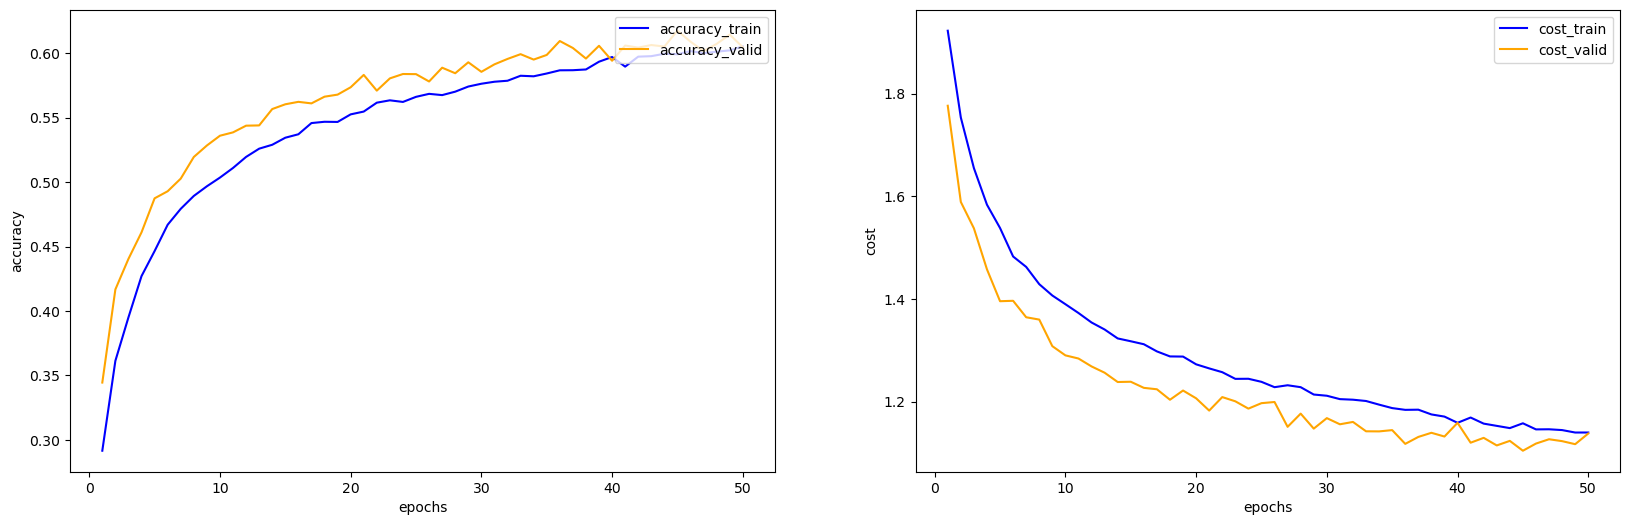

In [15]:

accuracy_train=[]
accuracy_valid=[]
cost_train=[]
cost_valid=[]#このリストをforの中にいれてしまうと新しいリストが毎回作られてしまう。必ず外に出すこと

for epoch in range(config['epochs']):
    losses_train = []  # 訓練誤差を格納しておくリスト
    losses_valid = []  # 検証データの誤差を格納しておくリスト

    conv_net.train()  # 訓練モードにする
    n_train = 0  # 訓練データ数
    acc_train = 0  # 訓練データに対する精度
    for x, t in dataloader_train:
        n_train += t.size()[0]

        conv_net.zero_grad()  # 勾配の初期化

        x = x.to(device)  # テンソルをGPUに移動

        t_hot = torch.eye(10)[t]  # 正解ラベルをone-hot vector化

        t = t.to(device)
        t_hot = t_hot.to(device)  # 正解ラベルとone-hot vectorをそれぞれGPUに移動

        y = conv_net.forward(x)  # 順伝播

        loss = -(t_hot*torch.log_softmax(y, dim=-1)).sum(axis=1).mean()  # 誤差(クロスエントロピー誤差関数)の計算

        loss.backward()  # 誤差の逆伝播

        optimizer.step()  # パラメータの更新

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())

    accuracy_train.append(acc_train/n_train)
    cost_train.append(np.mean(losses_train))

    conv_net.eval()  # 評価モードにする
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        n_val += t.size()[0]

        x = x.to(device)  # テンソルをGPUに移動

        t_hot = torch.eye(10)[t]  # 正解ラベルをone-hot vector化

        t = t.to(device)
        t_hot = t_hot.to(device)  # 正解ラベルとone-hot vectorをそれぞれGPUに移動

        y = conv_net.forward(x)  # 順伝播

        loss = -(t_hot*torch.log_softmax(y, dim=-1)).sum(axis=1).mean()  # 誤差(クロスエントロピー誤差関数)の計算

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())

    accuracy_valid.append(acc_val/n_val)
    cost_valid.append(np.mean(losses_valid))

    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(
        epoch+1,
        np.mean(losses_train),
        acc_train/n_train,
        np.mean(losses_valid),
        acc_val/n_val
    ))




x=np.arange(1,config['epochs']+1,1)
y1=accuracy_train
y2=cost_train
y3 = accuracy_valid
y4 = cost_valid
c1,c2= 'blue', 'orange'
l1,l2,l3,l4 = 'accuracy_train', 'cost_train','accuracy_valid','cost_valid'
xl1, xl2= 'epochs', 'epochs'
yl1, yl2= 'accuracy', 'cost'
fig = plt.figure(figsize = (20,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.plot(x, y1, color=c1, label=l1)
ax1.plot(x,y3,color=c2,label=l3)
ax2.plot(x, y2, color=c1, label=l2)
ax2.plot(x,y4,color=c2,label=l4)
ax1.set_xlabel(xl1)
ax2.set_xlabel(xl2)
ax1.set_ylabel(yl1)
ax2.set_ylabel(yl2)
ax1.legend(loc = 'upper right') 
ax2.legend(loc = 'upper right') 

plt.show()


cosine sheduler で学習率を最初は大きくして学習が進むにつれて学習率をだんだん小さくしていくように設定する(matureな神経細胞を表現している)

In [16]:
class CosineScheduler:
    def __init__(self, epochs, lr,warmup_length=5):
        """
        Arguments
        ---------
        epochs : int
            学習のエポック数．
        lr : float
            学習率．
        warmup_length : int
            warmupを適用するエポック数
        """
        self.epochs = epochs
        self.lr = lr
        self.warmup = warmup_length

    def __call__(self, epoch):
        """
        Arguments
        ---------
        epoch : int
            現在のエポック数．
        """
        progress = (epoch - self.warmup +1e-6) / (self.epochs - self.warmup +1e-6)
        progress = np.clip(progress, 0.0, 1.0)
        lr = self.lr * 0.5 * (1. + np.cos(np.pi * progress))

        if self.warmup:
            lr = lr * min(1., (epoch+1) / self.warmup)

        return lr


In [17]:
def set_lr(lr,optimizer):
    for param_group in optimizer.param_groups:
        param_group["lr"]=lr

In [18]:
config_tuning={
'lr':[0.01,0.001,0.0001],'warmup':[10,20]
}

config_normal={
    'epochs':100,
    'batch_size':100
}


In [19]:
def model(lr,warmup):
    for epoch in range(config_normal['epochs']):
        scheduler=CosineScheduler(epoch,lr,warmup)
        new_lr=scheduler(epoch)
        set_lr(new_lr,optimizer)

        losses_train=[]
        losses_valid=[]

        conv_net.train()
        n_train=0
        acc_train=0
        for x,t in dataloader_train:
            n_train += t.size()[0]
            conv_net.zero_grad()
            x=x.to(device)
            t_hot=torch.eye(10)[t]
            t=t.to(device)
            t_hot=t_hot.to(device)

            y=conv_net.forward(x)
            loss=-(t_hot*torch.log_softmax(y,dim=-1)).sum(axis=1).mean()
            loss.backward()
            optimizer.step()
            pred=y.argmax(1)

            acc_train+=(pred==t).float().sum().item()#pred==tでブール値を取り出して、.floatで数字に変換してそれのsumを取る.itemでテンソルの値をスカラー値に変換する。
            losses_train.append(loss.tolist())  

            train_loss=np.mean(losses_train)
            train_accuracy=acc_train/n_train


        conv_net.eval()  # 評価モードにする
        n_val = 0
        acc_val = 0
        for x, t in dataloader_valid:
            n_val += t.size()[0]

            x = x.to(device)  # テンソルをGPUに移動

            t_hot = torch.eye(10)[t]  # 正解ラベルをone-hot vector化

            t = t.to(device)
            t_hot = t_hot.to(device)  # 正解ラベルとone-hot vectorをそれぞれGPUに移動

            y = conv_net.forward(x)  # 順伝播

            loss = -(t_hot*torch.log_softmax(y, dim=-1)).sum(axis=1).mean()  # 誤差(クロスエントロピー誤差関数)の計算

            pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

            acc_val += (pred == t).float().sum().item()
            losses_valid.append(loss.tolist())

            valid_loss=np.mean(losses_valid)
            valid_accuracy=acc_val/n_val

    return train_loss,train_accuracy,valid_loss,valid_accuracy

In [21]:
model_num=0

for lr_params in config_tuning['lr']:
    for warmup_params in config_tuning['warmup']:
            with mlflow.start_run(nested=True):
                model_num +=1
                train_loss,train_accuracy,valid_loss,valid_accuracy=model(lr_params,warmup_params)

                print(f"model {model_num}: lr={lr_params}, warmup={warmup_params}, train_loss = {train_loss}, train_accuracy = {train_accuracy},valid_accuracy={valid_accuracy},valid_loss={valid_accuracy}")

                mlflow.log_param('lr',lr_params)
                mlflow.log_param('warmup',warmup_params)
                mlflow.log_metric('train_accuracy',train_accuracy)
                mlflow.log_metric('valid_accuracy',valid_accuracy)
                mlflow.log_metric('train_loss',train_loss)
                mlflow.log_metric('valid_loss',valid_loss)


model 1: lr=0.01, warmup=10, train_loss = 1.153643743544817, train_accuracy = 0.600025,valid_accuracy=0.5988,valid_loss=0.5988
model 2: lr=0.01, warmup=20, train_loss = 1.1567876374721526, train_accuracy = 0.597325,valid_accuracy=0.604,valid_loss=0.604
model 3: lr=0.001, warmup=10, train_loss = 1.1557541725039482, train_accuracy = 0.596875,valid_accuracy=0.6057,valid_loss=0.6057
model 4: lr=0.001, warmup=20, train_loss = 1.1459682239592075, train_accuracy = 0.601075,valid_accuracy=0.6041,valid_loss=0.6041
model 5: lr=0.0001, warmup=10, train_loss = 1.150210823714733, train_accuracy = 0.600025,valid_accuracy=0.6055,valid_loss=0.6055
model 6: lr=0.0001, warmup=20, train_loss = 1.1514583104848861, train_accuracy = 0.59845,valid_accuracy=0.6064,valid_loss=0.6064
